# Social Trends Analyzer
**Course:** Introduction to Computer Science (UFUG1601)  
**Semester:** Fall 2025  
**Topic:** Exploring Global Happiness, Education, and Economic Indicators

## 1. Project Overview
This project investigates the relationships between societal well-being (Happiness Score), economic prosperity (GDP per Capita), and education (Education Expenditure). We employ data analysis, visualization, and machine learning to explore these connections and generate AI-assisted insights.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import glob
import os
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Configuration
DATA_DIR = "./data/"
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

## 2. Data Loading and Integration
We load data from three sources:
1. **World Happiness Report** (CSV files for multiple years)
2. **GDP per Capita** (World Bank)
3. **Education Expenditure** (World Bank)

In [ ]:
def load_happiness_data(directory):
    dfs = []
    files = glob.glob(os.path.join(directory, "20*.csv"))
    
    if not files:
        print(f"WARNING: No CSV files found in {directory}")
        return pd.DataFrame()
        
    for file in files:
        try:
            year = int(os.path.basename(file).split('.')[0])
            df = pd.read_csv(file)
            df['Year'] = year
            
            # Normalize column names
            rename_map = {
                'Country': 'Country', 'Country or region': 'Country',
                'Happiness Score': 'Happiness_Score', 'Score': 'Happiness_Score',
                'Economy (GDP per Capita)': 'GDP_per_Capita', 'GDP per capita': 'GDP_per_Capita',
                'Health (Life Expectancy)': 'Life_Expectancy', 'Healthy life expectancy': 'Life_Expectancy',
                'Trust (Government Corruption)': 'Corruption', 'Perceptions of corruption': 'Corruption',
                'Freedom': 'Freedom', 'Freedom to make life choices': 'Freedom'
            }
            df = df.rename(columns=rename_map)
            
            cols_to_keep = ['Country', 'Year', 'Happiness_Score', 'GDP_per_Capita', 'Life_Expectancy', 'Freedom']
            available_cols = [c for c in cols_to_keep if c in df.columns]
            df = df[available_cols]
            dfs.append(df)
        except Exception as e:
            print(f"Skipping file {file}: {e}")

    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

def process_world_bank_data(filepath, value_name):
    if not os.path.exists(filepath):
        print(f"ERROR: File not found: {filepath}")
        return pd.DataFrame()
        
    try:
        df = pd.read_csv(filepath, skiprows=4)
        cols_to_drop = ['Country Code', 'Indicator Name', 'Indicator Code']
        df = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors='ignore')
        
        df_long = df.melt(id_vars=['Country Name'], var_name='Year', value_name=value_name)
        df_long = df_long.rename(columns={'Country Name': 'Country'})
        df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce')
        
        df_long = df_long.dropna(subset=['Year', value_name])
        df_long['Year'] = df_long['Year'].astype(int)
        
        return df_long
    except Exception as e:
        print(f"Error processing {filepath}: {e}")
        return pd.DataFrame()

In [3]:
# Load Datasets
happiness_df = load_happiness_data(os.path.join(DATA_DIR, "happiness"))
education_df = process_world_bank_data(os.path.join(DATA_DIR, "education_expenditure.csv"), "Education_Expenditure")
gdp_real_df = process_world_bank_data(os.path.join(DATA_DIR, "gdp_per_capita.csv"), "GDP_Real_USD")

# Merge Data
merged_df = pd.merge(happiness_df, gdp_real_df, on=['Country', 'Year'], how='inner')
merged_df = pd.merge(merged_df, education_df, on=['Country', 'Year'], how='left')

# Handle Missing Values (Imputation)
median_edu = merged_df['Education_Expenditure'].median()
merged_df['Education_Expenditure'] = merged_df['Education_Expenditure'].fillna(median_edu)

clean_df = merged_df.dropna().copy()
print(f"Final dataset shape: {clean_df.shape}")
clean_df.head()

--- Loading Happiness Data ---
--- Loading Education_Expenditure ---
--- Loading GDP_Real_USD ---
Final dataset shape: (530, 8)


,Country,Year,Happiness_Score,GDP_per_Capita,Life_Expectancy,Freedom,GDP_Real_USD,Education_Expenditure
0,Switzerland,2015,7.587,1.39651,0.94143,0.66557,83806.447600,4.99559
1,Iceland,2015,7.561,1.30232,0.94784,0.62877,52951.681511,7.45797
2,Denmark,2015,7.527,1.32548,0.87464,0.64938,53094.013361,4.32413
3,Norway,2015,7.522,1.45900,0.88521,0.66973,74809.965805,7.52335
4,Canada,2015,7.427,1.32629,0.90563,0.63297,43594.194105,4.73938


## 3. Descriptive Analysis
### 3.1 Global Happiness Rankings

In [4]:
# Top 10 Happiest Countries (Latest Year)
latest_year = clean_df['Year'].max()
latest_df = clean_df[clean_df['Year'] == latest_year]

top_10 = latest_df.nlargest(10, 'Happiness_Score')
bottom_10 = latest_df.nsmallest(10, 'Happiness_Score')

print(f"--- Top 10 Happiest Countries ({latest_year}) ---")
print(top_10[['Country', 'Happiness_Score']])

print(f"\n--- Bottom 10 Happiest Countries ({latest_year}) ---")
print(bottom_10[['Country', 'Happiness_Score']])

--- Top 10 Happiest Countries (2019) ---
         Country  Happiness_Score
532      Finland            7.769
533      Denmark            7.600
534       Norway            7.554
535      Iceland            7.494
536  Netherlands            7.488
537  Switzerland            7.480
538       Sweden            7.343
539  New Zealand            7.307
540       Canada            7.278
541      Austria            7.246

--- Bottom 10 Happiest Countries (2019) ---
                      Country  Happiness_Score
662  Central African Republic            3.083
661               Afghanistan            3.203
660                  Tanzania            3.231
659                    Rwanda            3.334
658                    Malawi            3.410
657                  Botswana            3.488
656                     Haiti            3.597
655                  Zimbabwe            3.663
654                   Burundi            3.775
653                   Lesotho            3.802


### 3.2 Correlation Analysis

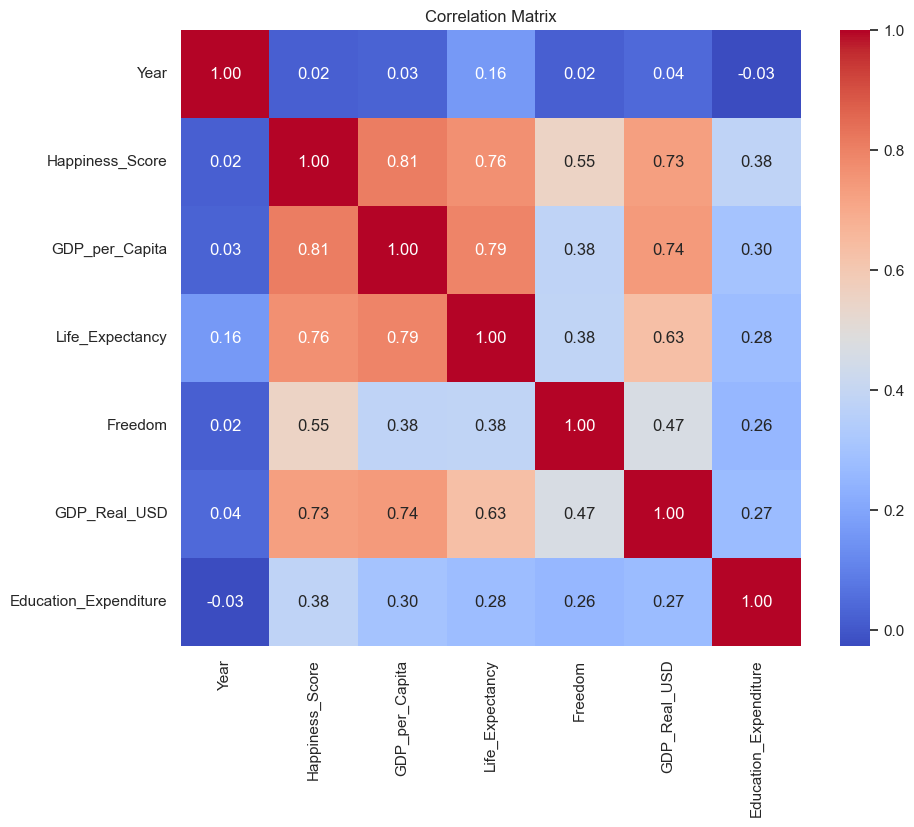

In [5]:
plt.figure(figsize=(10, 8))
numeric_df = clean_df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

### 3.3 World Map Visualization

In [6]:
fig = px.choropleth(
    latest_df,
    locations="Country",
    locationmode="country names",
    color="Happiness_Score",
    hover_name="Country",
    color_continuous_scale=px.colors.sequential.Plasma,
    title=f"Global Happiness Scores ({latest_year})"
)
fig.show()

C:\Users\yomi\AppData\Local\Temp\ipykernel_56488\1789756129.py:1: DeprecationWarning: The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.
  fig = px.choropleth(


## 4. Modeling
### 4.1 Linear Regression: Predicting Happiness

Model Performance:
 - MSE: 0.4282
 - R2 Score: 0.6602


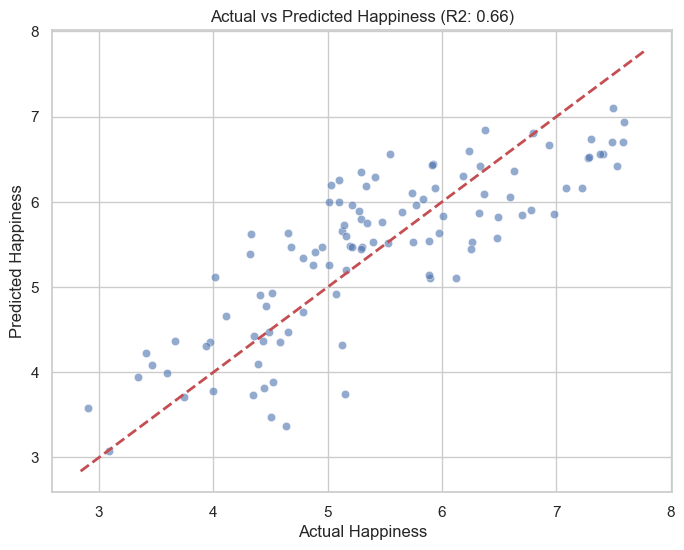

In [7]:
features = ['GDP_per_Capita', 'Life_Expectancy', 'Education_Expenditure']
target = 'Happiness_Score'

X = clean_df[features]
y = clean_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Model Performance:\n - MSE: {mse:.4f}\n - R2 Score: {r2:.4f}")

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=predictions, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel("Actual Happiness")
plt.ylabel("Predicted Happiness")
plt.title(f"Actual vs Predicted Happiness (R2: {r2:.2f})")
plt.show()

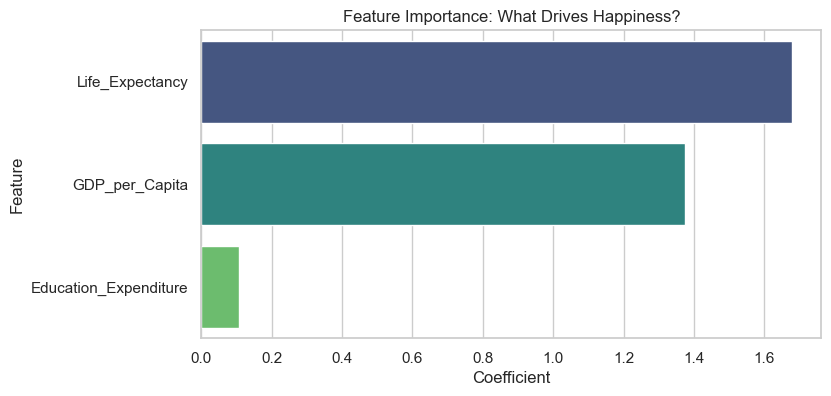

In [8]:
# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(data=feature_importance, x='Coefficient', y='Feature', hue='Feature', palette='viridis', legend=False)
plt.title("Feature Importance: What Drives Happiness?")
plt.show()

### 4.2 Clustering (K-Means)

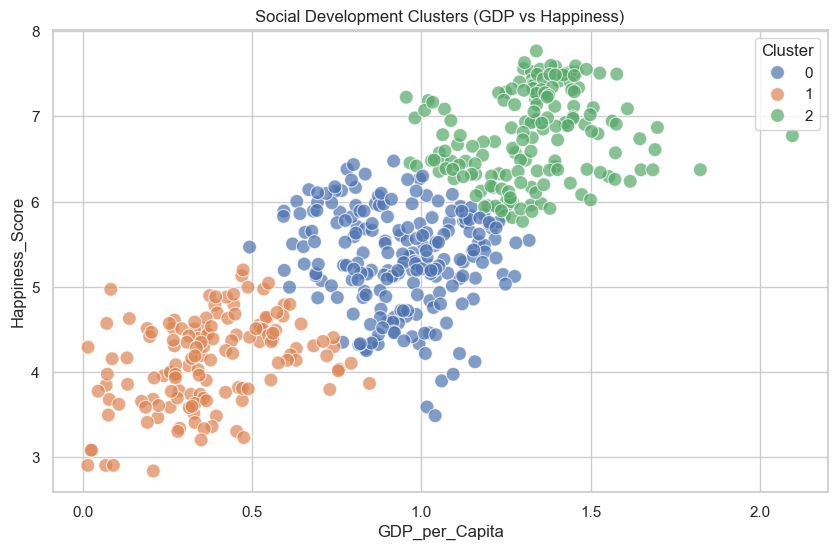

In [9]:
clustering_data = clean_df[['GDP_per_Capita', 'Happiness_Score']].copy()
scaler = StandardScaler()
clustering_scaled = scaler.fit_transform(clustering_data)

kmeans = KMeans(n_clusters=3, random_state=42)
clean_df['Cluster'] = kmeans.fit_predict(clustering_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=clean_df, x='GDP_per_Capita', y='Happiness_Score', 
                hue='Cluster', palette='deep', s=100, alpha=0.7)
plt.title('Social Development Clusters (GDP vs Happiness)')
plt.show()

## 5. AI Insights & Policy Generation
In this section, we use an LLM to generate insights based on our findings.

In [ ]:
# Load API Key and Configure Gemini
import yaml
import google.generativeai as genai
import time

def get_ai_response(prompt_text):
    try:
        with open("api_key.yaml", "r") as f:
            config = yaml.safe_load(f)
            api_key = config.get("Gemini_API_KEY")
            
        if not api_key or api_key.strip() == ".":
            return "⚠️ Please fill in your API Key in api_key.yaml"
        
        genai.configure(api_key=api_key)
        model = genai.GenerativeModel('gemini-pro')
        response = model.generate_content(prompt_text)
        return response.text
    except Exception as e:
        return f"❌ Error: {e}"

country_example = top_10.iloc[0]
prompt1 = f"""
Analyze the social well-being of {country_example['Country']} based on the following data:
Happiness Score: {country_example['Happiness_Score']:.2f}
GDP per Capita: {country_example['GDP_per_Capita']:.2f}
Life Expectancy: {country_example['Life_Expectancy']:.2f}
Provide 3 policy recommendations to maintain or improve this status.
"""
print(f"\n--- Prompt 1 ---")
print(get_ai_response(prompt1))
time.sleep(2) # Avoid rate limits

cluster_stats = clean_df.groupby('Cluster')[['Happiness_Score', 'GDP_per_Capita']].mean()
c0_stats = cluster_stats.iloc[0]
prompt2 = f"""
I have performed K-Means clustering on global happiness data. One cluster (Cluster 0) has the following average characteristics:
Happiness Score: {c0_stats['Happiness_Score']:.2f}
GDP per Capita: {c0_stats['GDP_per_Capita']:.2f}
Describe the likely socio-economic profile of countries in this cluster. What are the common challenges they might face?
"""
print("\n--- Prompt 2 ---")
print(get_ai_response(prompt2))
time.sleep(2)

# --- Prompt 3: Global Trend Synthesis ---
# Get correlation values
corr_matrix = numeric_df.corr()
gdp_corr = corr_matrix.loc['Happiness_Score', 'GDP_per_Capita']
edu_corr = corr_matrix.loc['Happiness_Score', 'Education_Expenditure']

prompt3 = f"""
Based on a correlation analysis of global data, I found:
Correlation between GDP per Capita and Happiness: {gdp_corr:.2f}
Correlation between Education Expenditure and Happiness: {edu_corr:.2f}
Explain why economic factors might have a different observed impact on happiness scores compared to education spending in the short term.
"""
print("\n--- Prompt 3 ---")
print(get_ai_response(prompt3))


✅ API Key loaded successfully
--- Generated Prompt ---

Analyze the social well-being of Finland based on the following data:
- Happiness Score: 7.77
- GDP per Capita: 1.34
- Life Expectancy: 0.99

Provide 3 policy recommendations to maintain or improve this status.


--- Calling Gemini API ---
Of course. Here is an analysis of Finland's social well-being based on the data, followed by three policy recommendations.

### **Analysis of Social Well-being in Finland**

Based on the provided data, Finland exhibits an **exceptionally high level of social well-being**, positioning it as a global leader. The three indicators work together to paint a picture of a prosperous, healthy, and satisfied society.

*   **Happiness Score (7.77):** This is the headline indicator. A score of 7.77 (on a scale typically from 0 to 10) is extremely high and is consistent with Finland's repeated ranking as the happiest country in the world. This score reflects a high degree of life satisfaction among its citiz